In [ ]:
# pip install onn
# install 후, ONN 소스코드를 ./onn 폴더의 OnlineNeuralNetwork.py로 교체해야함!

Note: you may need to restart the kernel to use updated packages.


In [20]:
import numpy as np
np.float = np
np.int = np

In [23]:
import pandas as pd
import random
import os
import torch
from torch import nn
from onn.OnlineNeuralNetwork import ONN
from tqdm import tqdm
from river import preprocessing
from D3 import D3
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.data_stream import DataStream
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')


In [24]:
def set_env(seed):
    torch.cuda.set_device(0)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # os.environ['OMP_NUM_THREADS'] = '1'


def prequential_eval(test_y, y_pred):
    chunk_num = 30
    chunk_size = len(test_y) // chunk_num

    acc_list = []
    f1_list = []

    for i in range(chunk_num):
        start_idx = i*chunk_size
        end_idx = (i+1)*chunk_size
        if i == (chunk_num-1):
            chunk_y = test_y[start_idx:]
            chunk_pred = y_pred[start_idx:]
        else:
            chunk_y = test_y[start_idx:end_idx]
            chunk_pred = y_pred[start_idx:end_idx]

        acc_list.append(accuracy_score(chunk_y, chunk_pred))
        f1_list.append(f1_score(chunk_y, chunk_pred))

    return acc_list, f1_list

def plot_acc_f1(acc_list, f1_list):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(range(30), acc_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
    ax[0].set_xlabel('Percentage of data')
    ax[0].set_ylabel('Accuracy')
    ax[0].grid(True)
    ax[0].set_title('Accuracy Plot')

    ax[1].plot(range(30), f1_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
    ax[1].set_xlabel('Percentage of data')
    ax[1].set_ylabel('F1 Score')
    ax[1].grid(True)
    ax[1].set_title('F1 Score Plot')

    plt.tight_layout()
    plt.show()

def plot_acc_f1_together(offline_acc_list, offline_f1_list, online_acc_list, online_f1_list):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(range(30), offline_acc_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5, label="Offline")
    ax[0].plot(range(30), online_acc_list, marker='o', color='r', linestyle='-', linewidth=2, markersize=5, label="Online")
    ax[0].set_xlabel('Percentage of data')
    ax[0].set_ylabel('Accuracy')
    ax[0].grid(True)
    ax[0].set_title('Accuracy Plot')
    ax[0].legend()

    ax[1].plot(range(30), offline_f1_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5, label="Offline")
    ax[1].plot(range(30), online_f1_list, marker='o', color='r', linestyle='-', linewidth=2, markersize=5, label="Online")
    ax[1].set_xlabel('Percentage of data')
    ax[1].set_ylabel('F1 Score')
    ax[1].grid(True)
    ax[1].set_title('F1 Score Plot')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
df = pd.read_csv('./경진대회용 주조 공정최적화 데이터셋.csv', encoding='cp949', index_col=0)
df.dropna(subset=['emergency_stop', 'upper_mold_temp3','lower_mold_temp3'], inplace=True)
df.reset_index(inplace=True, drop=True)
df = df[['registration_time','facility_operation_cycleTime','production_cycletime', 'low_section_speed', 'high_section_speed','cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3','lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3','sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time','passorfail']]
df['registration_time'] = pd.to_datetime(df['registration_time'])
set_env(42)
display(df)

In [28]:
train_df = df[df['registration_time'] <= '2019-01-30 08:00:00']
test_df = df[df['registration_time'] > '2019-01-30 08:00:00']

train_X = train_df.drop(['registration_time','passorfail'],axis=1)
train_y = train_df['passorfail']

test_X = test_df.drop(['registration_time','passorfail'],axis=1)
test_y = test_df['passorfail']

new_column_names = {train_X.columns[i]: i for i in range(16)}

train_X = train_X.rename(columns=new_column_names)
test_X = test_X.rename(columns=new_column_names)

In [ ]:
scaler = preprocessing.StandardScaler()

scaler.learn_many(train_X)
train_X_scaled = scaler.transform_many(train_X).values

In [ ]:
w_size = 400
rho = 0.5
d3 = D3(w=w_size, rho=rho, dim=16, auc=0.85)

# Offline

In [ ]:
onn_network = ONN(features_size=train_X_scaled.shape[1],
                  max_num_hidden_layers=2,
                  qtd_neuron_per_hidden_layer=10,
                  n_classes=train_y.nunique(),
                  use_cuda=True
                  )

for i in tqdm(range(len(train_X_scaled))):
    onn_network.partial_fit(np.asarray([train_X_scaled[i]]), np.asarray([train_y.iloc[i]]), show_loss=False)

Using CUDA :]


100%|██████████| 26461/26461 [00:19<00:00, 1386.77it/s]


In [ ]:
save_path = "./Offline_onn_params.pth"

state_dict = torch.load(save_path)

onn_network = ONN(features_size=train_X_scaled.shape[1],
                  max_num_hidden_layers=2,
                  qtd_neuron_per_hidden_layer=10,
                  n_classes=train_y.nunique(),
                  use_cuda=True
                 )

missing_keys, unexpected_keys = onn_network.load_state_dict(state_dict, strict=False)
onn_network.alpha = state_dict["alpha"].to(onn_network.device)
onn_network.to(onn_network.device)

Using CUDA :]


ONN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (output_layers): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=2, bias=True)
  )
)

In [ ]:
test_X_scaled = scaler.transform_many(test_X).values

y_pred = onn_network.predict(test_X_scaled)
accuracy = accuracy_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)
report = classification_report(test_y, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.8566239021474227
F1 Score: 0.32878874856486795
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.86      0.92     62354
         1.0       0.21      0.79      0.33      2887

    accuracy                           0.86     65241
   macro avg       0.60      0.83      0.62     65241
weighted avg       0.95      0.86      0.89     65241



In [ ]:
df = pd.DataFrame({
    'Prediction': y_pred,
    'Actual': test_y
})

df.to_csv('./Offline_ONN_results.csv', index=False)

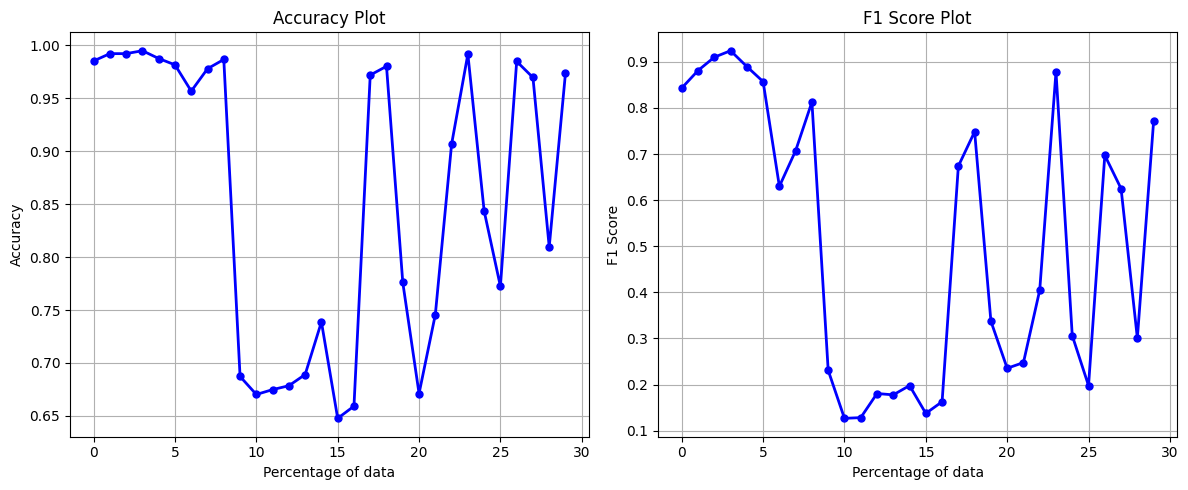

In [ ]:
offline_acc_list, offline_f1_list = prequential_eval(test_y,y_pred)
plot_acc_f1(offline_acc_list, offline_f1_list)

In [ ]:
save_path = "./Offline_onn_params.pth"

torch.save(onn_network.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./Offline_onn_params.pth


# Online

In [ ]:
save_path = "./Offline_onn_params.pth"

state_dict = torch.load(save_path)

onn_network = ONN(features_size=train_X_scaled.shape[1],
                  max_num_hidden_layers=2,
                  qtd_neuron_per_hidden_layer=10,
                  n_classes=train_y.nunique(),
                  use_cuda=True
                 )

missing_keys, unexpected_keys = onn_network.load_state_dict(state_dict, strict=False)
onn_network.alpha = state_dict["alpha"].to(onn_network.device)
onn_network.to(onn_network.device)

Using CUDA :]


ONN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (output_layers): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=2, bias=True)
  )
)

In [ ]:
stream = DataStream(data=test_X.values, y=test_y.values)
pred_li_2 = []
i = 0

for x, y in zip(train_X.values[-w_size:, :], train_y.values[-w_size:]):
    d3.addInstance(x, y)

In [ ]:
while stream.has_more_samples():
    X, y = stream.next_sample()

    X_scaled = scaler.transform_one(dict(enumerate(X[0])))
    X_scaled = np.array([list(X_scaled.values())])

    y_hat = onn_network.predict(X_scaled)
    pred_li_2.append(y_hat.item())

    if d3.isEmpty():
        d3.addInstance(X, y)
    else:
        if d3.driftCheck():
            print(f"Concept drift detected at sample {i}")

            drift_X, drift_y = d3.getCurrentData(), d3.getCurrentLabels()
            scaler.learn_many(pd.DataFrame(drift_X))
            drift_X_scaled = scaler.transform_many(pd.DataFrame(drift_X)).values

            for j in tqdm(range(len(drift_X_scaled))):
                onn_network.partial_fit(np.asarray([drift_X_scaled[j]]), np.asarray([drift_y[j]]),show_loss=False)

            d3.addInstance(X, y)
        else:
            d3.addInstance(X, y)

    i += 1

Concept drift detected at sample 200


100%|██████████| 200/200 [00:00<00:00, 1301.55it/s]


Concept drift detected at sample 1000


100%|██████████| 200/200 [00:00<00:00, 1267.01it/s]


Concept drift detected at sample 2000


100%|██████████| 200/200 [00:00<00:00, 1301.00it/s]


Concept drift detected at sample 2600


100%|██████████| 200/200 [00:00<00:00, 1275.15it/s]


Concept drift detected at sample 3200


100%|██████████| 200/200 [00:00<00:00, 1296.01it/s]


Concept drift detected at sample 3800


100%|██████████| 200/200 [00:00<00:00, 1420.04it/s]


Concept drift detected at sample 4400


100%|██████████| 200/200 [00:00<00:00, 1444.25it/s]


Concept drift detected at sample 4800


100%|██████████| 200/200 [00:00<00:00, 1445.35it/s]


Concept drift detected at sample 5200


100%|██████████| 200/200 [00:00<00:00, 1443.19it/s]


Concept drift detected at sample 5600


100%|██████████| 200/200 [00:00<00:00, 1446.31it/s]


Concept drift detected at sample 6000


100%|██████████| 200/200 [00:00<00:00, 1411.03it/s]


Concept drift detected at sample 6600


100%|██████████| 200/200 [00:00<00:00, 1430.63it/s]


Concept drift detected at sample 7200


100%|██████████| 200/200 [00:00<00:00, 1421.76it/s]


Concept drift detected at sample 7800


100%|██████████| 200/200 [00:00<00:00, 1443.95it/s]


Concept drift detected at sample 8400


100%|██████████| 200/200 [00:00<00:00, 1450.16it/s]


Concept drift detected at sample 8800


100%|██████████| 200/200 [00:00<00:00, 1428.10it/s]


Concept drift detected at sample 9400


100%|██████████| 200/200 [00:00<00:00, 1418.25it/s]


Concept drift detected at sample 9800


100%|██████████| 200/200 [00:00<00:00, 1412.80it/s]


Concept drift detected at sample 10200


100%|██████████| 200/200 [00:00<00:00, 1427.50it/s]


Concept drift detected at sample 10600


100%|██████████| 200/200 [00:00<00:00, 1392.73it/s]


Concept drift detected at sample 11000


100%|██████████| 200/200 [00:00<00:00, 1374.27it/s]


Concept drift detected at sample 11400


100%|██████████| 200/200 [00:00<00:00, 1420.20it/s]


Concept drift detected at sample 11800


100%|██████████| 200/200 [00:00<00:00, 1438.91it/s]


Concept drift detected at sample 12400


100%|██████████| 200/200 [00:00<00:00, 1376.03it/s]


Concept drift detected at sample 12800


100%|██████████| 200/200 [00:00<00:00, 1350.23it/s]


Concept drift detected at sample 13400


100%|██████████| 200/200 [00:00<00:00, 1445.38it/s]


Concept drift detected at sample 13800


100%|██████████| 200/200 [00:00<00:00, 1446.16it/s]


Concept drift detected at sample 14200


100%|██████████| 200/200 [00:00<00:00, 1450.03it/s]


Concept drift detected at sample 14600


100%|██████████| 200/200 [00:00<00:00, 1438.67it/s]


Concept drift detected at sample 15000


100%|██████████| 200/200 [00:00<00:00, 1446.23it/s]


Concept drift detected at sample 15400


100%|██████████| 200/200 [00:00<00:00, 1419.20it/s]


Concept drift detected at sample 15800


100%|██████████| 200/200 [00:00<00:00, 1341.82it/s]


Concept drift detected at sample 16200


100%|██████████| 200/200 [00:00<00:00, 1447.02it/s]


Concept drift detected at sample 16600


100%|██████████| 200/200 [00:00<00:00, 1364.17it/s]


Concept drift detected at sample 17200


100%|██████████| 200/200 [00:00<00:00, 1421.03it/s]


Concept drift detected at sample 17800


100%|██████████| 200/200 [00:00<00:00, 1238.27it/s]


Concept drift detected at sample 18200


100%|██████████| 200/200 [00:00<00:00, 1417.04it/s]


Concept drift detected at sample 18600


100%|██████████| 200/200 [00:00<00:00, 1389.47it/s]


Concept drift detected at sample 19000


100%|██████████| 200/200 [00:00<00:00, 1394.05it/s]


Concept drift detected at sample 20000


100%|██████████| 200/200 [00:00<00:00, 1149.11it/s]


Concept drift detected at sample 20400


100%|██████████| 200/200 [00:00<00:00, 1118.33it/s]


Concept drift detected at sample 20800


100%|██████████| 200/200 [00:00<00:00, 1272.91it/s]


Concept drift detected at sample 21400


100%|██████████| 200/200 [00:00<00:00, 1273.19it/s]


Concept drift detected at sample 22000


100%|██████████| 200/200 [00:00<00:00, 1259.04it/s]


Concept drift detected at sample 22600


100%|██████████| 200/200 [00:00<00:00, 1262.64it/s]


Concept drift detected at sample 23000


100%|██████████| 200/200 [00:00<00:00, 1434.53it/s]


Concept drift detected at sample 23800


100%|██████████| 200/200 [00:00<00:00, 1267.34it/s]


Concept drift detected at sample 24200


100%|██████████| 200/200 [00:00<00:00, 1259.51it/s]


Concept drift detected at sample 24600


100%|██████████| 200/200 [00:00<00:00, 1272.51it/s]


Concept drift detected at sample 25000


100%|██████████| 200/200 [00:00<00:00, 1266.99it/s]


Concept drift detected at sample 25400


100%|██████████| 200/200 [00:00<00:00, 1242.71it/s]


Concept drift detected at sample 26200


100%|██████████| 200/200 [00:00<00:00, 1286.33it/s]


Concept drift detected at sample 26800


100%|██████████| 200/200 [00:00<00:00, 1289.43it/s]


Concept drift detected at sample 27200


100%|██████████| 200/200 [00:00<00:00, 1302.34it/s]


Concept drift detected at sample 27600


100%|██████████| 200/200 [00:00<00:00, 1282.09it/s]


Concept drift detected at sample 28200


100%|██████████| 200/200 [00:00<00:00, 1420.13it/s]


Concept drift detected at sample 28800


100%|██████████| 200/200 [00:00<00:00, 1266.67it/s]


Concept drift detected at sample 30000


100%|██████████| 200/200 [00:00<00:00, 1280.44it/s]


Concept drift detected at sample 30800


100%|██████████| 200/200 [00:00<00:00, 1295.50it/s]


Concept drift detected at sample 31200


100%|██████████| 200/200 [00:00<00:00, 1284.58it/s]


Concept drift detected at sample 31800


100%|██████████| 200/200 [00:00<00:00, 1424.71it/s]


Concept drift detected at sample 32800


100%|██████████| 200/200 [00:00<00:00, 1368.88it/s]


Concept drift detected at sample 33400


100%|██████████| 200/200 [00:00<00:00, 1283.47it/s]


Concept drift detected at sample 34000


100%|██████████| 200/200 [00:00<00:00, 1434.86it/s]


Concept drift detected at sample 34800


100%|██████████| 200/200 [00:00<00:00, 1399.19it/s]


Concept drift detected at sample 35200


100%|██████████| 200/200 [00:00<00:00, 1458.56it/s]


Concept drift detected at sample 36000


100%|██████████| 200/200 [00:00<00:00, 1397.12it/s]


Concept drift detected at sample 36400


100%|██████████| 200/200 [00:00<00:00, 1462.91it/s]


Concept drift detected at sample 36800


100%|██████████| 200/200 [00:00<00:00, 1461.39it/s]


Concept drift detected at sample 37200


100%|██████████| 200/200 [00:00<00:00, 1451.16it/s]


Concept drift detected at sample 37600


100%|██████████| 200/200 [00:00<00:00, 1453.60it/s]


Concept drift detected at sample 38000


100%|██████████| 200/200 [00:00<00:00, 1456.20it/s]


Concept drift detected at sample 39000


100%|██████████| 200/200 [00:00<00:00, 1450.82it/s]


Concept drift detected at sample 39800


100%|██████████| 200/200 [00:00<00:00, 1451.55it/s]


Concept drift detected at sample 40200


100%|██████████| 200/200 [00:00<00:00, 1442.43it/s]


Concept drift detected at sample 41000


100%|██████████| 200/200 [00:00<00:00, 1364.85it/s]


Concept drift detected at sample 41600


100%|██████████| 200/200 [00:00<00:00, 1369.83it/s]


Concept drift detected at sample 42200


100%|██████████| 200/200 [00:00<00:00, 1327.13it/s]


Concept drift detected at sample 42600


100%|██████████| 200/200 [00:00<00:00, 1456.15it/s]


Concept drift detected at sample 43200


100%|██████████| 200/200 [00:00<00:00, 1455.81it/s]


Concept drift detected at sample 43600


100%|██████████| 200/200 [00:00<00:00, 1432.48it/s]


Concept drift detected at sample 44000


100%|██████████| 200/200 [00:00<00:00, 1415.38it/s]


Concept drift detected at sample 44400


100%|██████████| 200/200 [00:00<00:00, 1283.27it/s]


Concept drift detected at sample 45200


100%|██████████| 200/200 [00:00<00:00, 1398.52it/s]


Concept drift detected at sample 45600


100%|██████████| 200/200 [00:00<00:00, 1345.82it/s]


Concept drift detected at sample 46200


100%|██████████| 200/200 [00:00<00:00, 1319.02it/s]


Concept drift detected at sample 47000


100%|██████████| 200/200 [00:00<00:00, 1372.42it/s]


Concept drift detected at sample 47400


100%|██████████| 200/200 [00:00<00:00, 1358.05it/s]


Concept drift detected at sample 47800


100%|██████████| 200/200 [00:00<00:00, 1241.83it/s]


Concept drift detected at sample 48800


100%|██████████| 200/200 [00:00<00:00, 1250.98it/s]


Concept drift detected at sample 49200


100%|██████████| 200/200 [00:00<00:00, 1286.53it/s]


Concept drift detected at sample 49600


100%|██████████| 200/200 [00:00<00:00, 1240.74it/s]


Concept drift detected at sample 50200


100%|██████████| 200/200 [00:00<00:00, 1247.89it/s]


Concept drift detected at sample 50600


100%|██████████| 200/200 [00:00<00:00, 1257.27it/s]


Concept drift detected at sample 51200


100%|██████████| 200/200 [00:00<00:00, 1278.08it/s]


Concept drift detected at sample 51600


100%|██████████| 200/200 [00:00<00:00, 1267.05it/s]


Concept drift detected at sample 52000


100%|██████████| 200/200 [00:00<00:00, 1245.80it/s]


Concept drift detected at sample 52600


100%|██████████| 200/200 [00:00<00:00, 1256.84it/s]


Concept drift detected at sample 53000


100%|██████████| 200/200 [00:00<00:00, 1257.85it/s]


Concept drift detected at sample 53800


100%|██████████| 200/200 [00:00<00:00, 1267.42it/s]


Concept drift detected at sample 54200


100%|██████████| 200/200 [00:00<00:00, 1262.43it/s]


Concept drift detected at sample 54600


100%|██████████| 200/200 [00:00<00:00, 1282.20it/s]

Concept drift detected at sample 55000



100%|██████████| 200/200 [00:00<00:00, 1277.53it/s]


Concept drift detected at sample 55400


100%|██████████| 200/200 [00:00<00:00, 1268.35it/s]


Concept drift detected at sample 55800


100%|██████████| 200/200 [00:00<00:00, 1285.34it/s]

Concept drift detected at sample 56200



100%|██████████| 200/200 [00:00<00:00, 1268.26it/s]


Concept drift detected at sample 56600


100%|██████████| 200/200 [00:00<00:00, 1268.56it/s]


Concept drift detected at sample 57000


100%|██████████| 200/200 [00:00<00:00, 1277.34it/s]

Concept drift detected at sample 57400



100%|██████████| 200/200 [00:00<00:00, 1303.02it/s]


Concept drift detected at sample 57800


100%|██████████| 200/200 [00:00<00:00, 1290.07it/s]


Concept drift detected at sample 58200


100%|██████████| 200/200 [00:00<00:00, 1240.03it/s]


Concept drift detected at sample 58600


100%|██████████| 200/200 [00:00<00:00, 1274.54it/s]

Concept drift detected at sample 59000



100%|██████████| 200/200 [00:00<00:00, 1272.62it/s]


Concept drift detected at sample 59400


100%|██████████| 200/200 [00:00<00:00, 1273.60it/s]


Concept drift detected at sample 60200


100%|██████████| 200/200 [00:00<00:00, 1261.42it/s]


Concept drift detected at sample 60600


100%|██████████| 200/200 [00:00<00:00, 1252.81it/s]


Concept drift detected at sample 61200


100%|██████████| 200/200 [00:00<00:00, 1266.66it/s]


Concept drift detected at sample 61600


100%|██████████| 200/200 [00:00<00:00, 1264.52it/s]


Concept drift detected at sample 62000


100%|██████████| 200/200 [00:00<00:00, 1270.78it/s]


Concept drift detected at sample 62600


100%|██████████| 200/200 [00:00<00:00, 1279.16it/s]

Concept drift detected at sample 63000



100%|██████████| 200/200 [00:00<00:00, 1321.44it/s]


Concept drift detected at sample 63400


100%|██████████| 200/200 [00:00<00:00, 1423.75it/s]


Concept drift detected at sample 63800


100%|██████████| 200/200 [00:00<00:00, 1437.32it/s]


Concept drift detected at sample 64200


100%|██████████| 200/200 [00:00<00:00, 1450.25it/s]


Concept drift detected at sample 64600


100%|██████████| 200/200 [00:00<00:00, 1439.02it/s]


Concept drift detected at sample 65000


100%|██████████| 200/200 [00:00<00:00, 1403.33it/s]


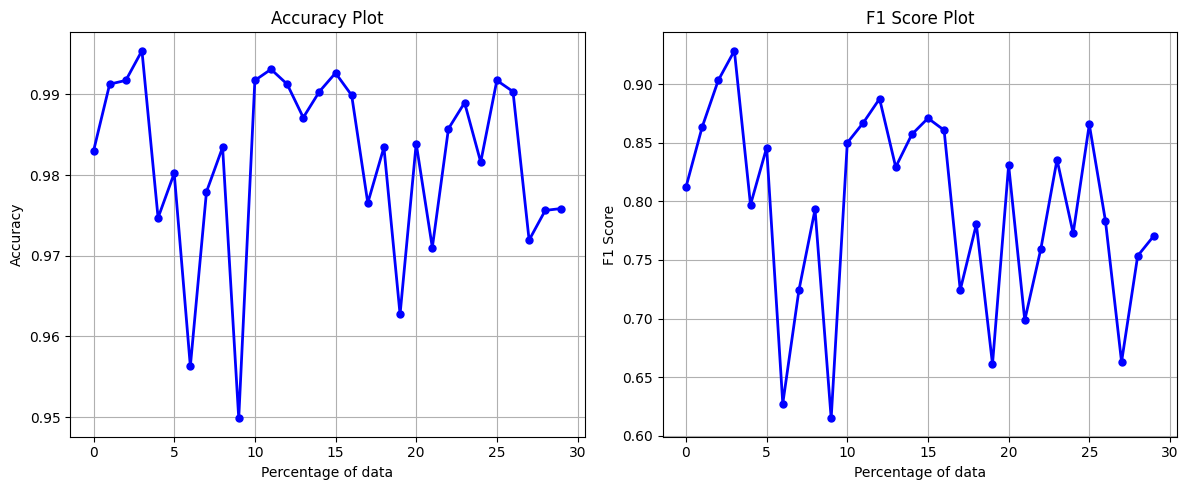

In [ ]:
online_acc_list, online_f1_list = prequential_eval(test_y,pred_li_2)
plot_acc_f1(online_acc_list, online_f1_list)

Using CUDA :]


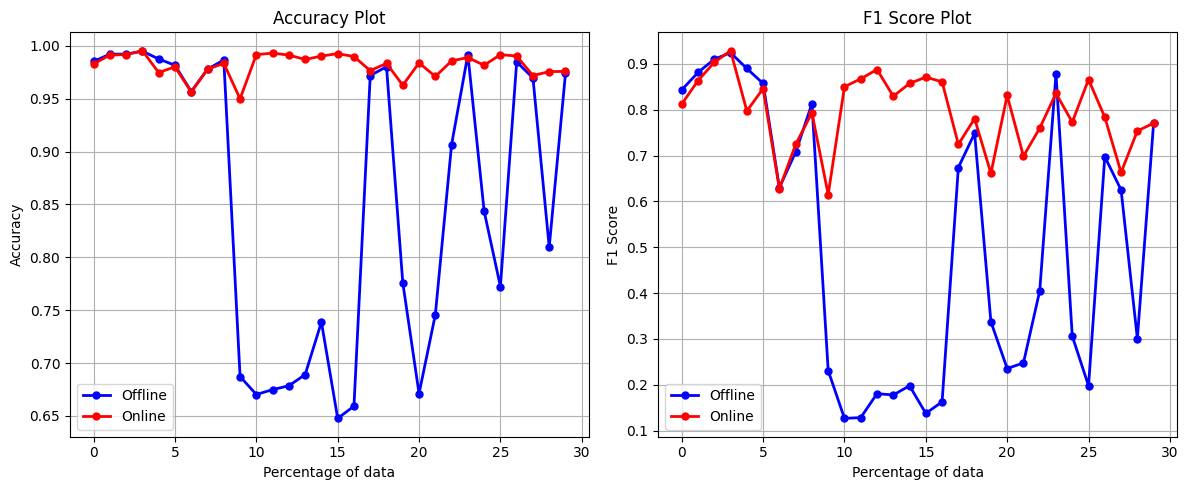

In [ ]:
save_path = "./Offline_onn_params.pth"

state_dict = torch.load(save_path)

offline_onn_network = ONN(features_size=train_X_scaled.shape[1],
                  max_num_hidden_layers=2,
                  qtd_neuron_per_hidden_layer=10,
                  n_classes=train_y.nunique(),
                  use_cuda=True
                 )

missing_keys, unexpected_keys = offline_onn_network.load_state_dict(state_dict, strict=False)
offline_onn_network.alpha = state_dict["alpha"].to(offline_onn_network.device)
offline_onn_network.to(offline_onn_network.device)
scaler = preprocessing.StandardScaler()

scaler.learn_many(train_X)
train_X_scaled = scaler.transform_many(train_X).values

test_X_scaled = scaler.transform_many(test_X).values

y_pred = offline_onn_network.predict(test_X_scaled)

offline_acc_list, offline_f1_list = prequential_eval(test_y,y_pred)

plot_acc_f1_together(offline_acc_list, offline_f1_list, online_acc_list, online_f1_list)

In [ ]:
accuracy = accuracy_score(test_y, pred_li_2)
f1 = f1_score(test_y, pred_li_2)
report = classification_report(test_y, pred_li_2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.9819745252218697
F1 Score: 0.7824639289678136
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     62354
         1.0       0.84      0.73      0.78      2887

    accuracy                           0.98     65241
   macro avg       0.91      0.86      0.89     65241
weighted avg       0.98      0.98      0.98     65241



In [ ]:
save_path = "model_params/Online_onn_params.pth"

torch.save(onn_network.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./Online_onn_params.pth


In [ ]:
df = pd.DataFrame({
    'Prediction': pred_li_2,
    'Actual': test_y
})

# CSV 파일로 저장
df.to_csv('pred_results/Online_ONN_results.csv', index=False)